In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
import numpy as np
from scipy.stats import norm

In [5]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *

set_seed()

### Importing or making the PINN

In [6]:
specs = {
        't': {'range': 5.0},
       'm':  {'mean': 1.0,  'std': 0.1, 'lower_multiplier': -2, 'upper_multiplier': 8},
       'mu': {'mean': 0.6,  'std': 0.05, 'lower_multiplier': -8, 'upper_multiplier': 2},
       'k':  {'mean': 5.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'y0': {'mean': -0.4, 'std': 0.1, 'lower_multiplier': -5, 'upper_multiplier': 5},
       'v0': {'mean': 3.0,  'std': 0.5, 'lower_multiplier': -5, 'upper_multiplier': 5},
    }

# Run training pipeline
params=initialize_param(1000,distribute=['m','mu'],specs=specs, normalize=True)
#,'k','y0','v0'

# I only normalize the input parameters that are diustributed. That means that if training on all params, it expects 0 for mean. But if I change distribute to only 
# some params, I need to change the mean of the other params to 0 for it to be correct. 

In [ ]:
vanilla_model = PINN_vanilla_oscillator(hidden_size=20, hidden_layers=3)

P2INN_model = P2INN_oscillator(
                 param_hidden= 10,
                 param_layers= 4,
                 coord_hidden= 10,
                 coord_layers = 3,
                 decoder_hidden = 20,
                 decoder_layers = 6)

optimizer = optim.Adam(vanilla_model.parameters(), lr=0.001)
trainer = Trainer(vanilla_model, optimizer,epochs=4001, lambda_bc=2.0)
trainer.train(params)

In [ ]:
import os

# Save the model's state dictionary to the "Trained models" folder
model_path = "Trained models/m_mu_1000_norm_4001_vanilla_newstds.pth"

if os.path.exists(model_path):
    response = input(f"The file '{model_path}' already exists. Do you want to replace it? (yes/no): ").strip().lower()
    if response != 'yes':
        print("Model saving aborted.")
    else:
        torch.save(vanilla_model.state_dict(), model_path)
        print(f"Model's state dictionary saved to {model_path}")
else:
    torch.save(vanilla_model.state_dict(), model_path)
    print(f"Model's state dictionary saved to {model_path}")

In [ ]:
P2INN_model = P2INN_oscillator(10, 4, 10, 3, 20, 6)
# Load the saved state dictionary with weights_only=True
P2INN_model.load_state_dict(torch.load("Trained models/" \
"m_mu_500_norm_4001.pth"
, weights_only=True))
P2INN_model.eval()

In [7]:
PINN_model = PINN_vanilla_oscillator()
# Load the saved state dictionary with weights_only=True
PINN_model.load_state_dict(torch.load("Trained models/" \
"m_mu_500_norm_4001.pth"
, weights_only=True))
PINN_model.eval()

PINN_vanilla_oscillator(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [8]:
m_mean, m_std = specs['m']['mean'], specs['m']['std']
mu_mean, mu_std = specs['mu']['mean'], specs['mu']['std']
k_mean, k_std = specs['k']['mean'], specs['k']['std']
y0_mean, y0_std = specs['y0']['mean'], specs['y0']['std']
v0_mean, v0_std = specs['v0']['mean'], specs['v0']['std']

N=100
t_coll = torch.linspace(0, 5, N).view(-1, 1) / specs['t']['range']
t_test = np.linspace(0, 5, N)

In [9]:
# def inspect_activations(model, x):
#     """
#     Feeds x through model.net and prints min/max pre-activations for each Linear layer.
#     x should be shape (1,6).
#     """
#     activ = x
#     layer_i = 0
#     for layer in model.net:
#         if isinstance(layer, nn.Linear):
#             z = layer(activ)
#             print(f"Layer {layer_i} pre-act:  min {z.min().item():.2f}, max {z.max().item():.2f}")
#             activ = z
#             layer_i += 1
#         else:  # nn.Tanh (or any activation)
#             activ = layer(activ)

# # Reconstruct each input as a (1,1) Tensor
# τ_test  = torch.tensor([[0.0]])  # normalized time = 0
# m_z_val = (4.0 - m_mean) / m_std
# mu_z_val = (mu_mean - mu_mean) / mu_std  # e.g. 0 at mean
# k_z_val  = 0.0
# y0_z_val = 0.0
# v0_z_val = (4.0 - v0_mean) / v0_std

# # Wrap each in a 1×1 Tensor
# m_z   = torch.tensor([[m_z_val]],   dtype=torch.float32)
# mu_z  = torch.tensor([[mu_z_val]],  dtype=torch.float32)
# k_z   = torch.tensor([[k_z_val]],   dtype=torch.float32)
# y0_z  = torch.tensor([[y0_z_val]],  dtype=torch.float32)
# v0_z  = torch.tensor([[v0_z_val]],  dtype=torch.float32)

# # Now concatenate along dim=1 to get shape (1,6)
# x_test = torch.cat([τ_test, m_z, mu_z, k_z, y0_z, v0_z], dim=1)

# # And inspect all layers’ pre‐activations:
# inspect_activations(PINN_model, x_test)

### Evaluating model performance

In [10]:
print(params.keys())
print(params['norm_info'])

dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
{'t': {'range': 5.0}, 'm': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}


<!-- m, mu, k, y0 not norm
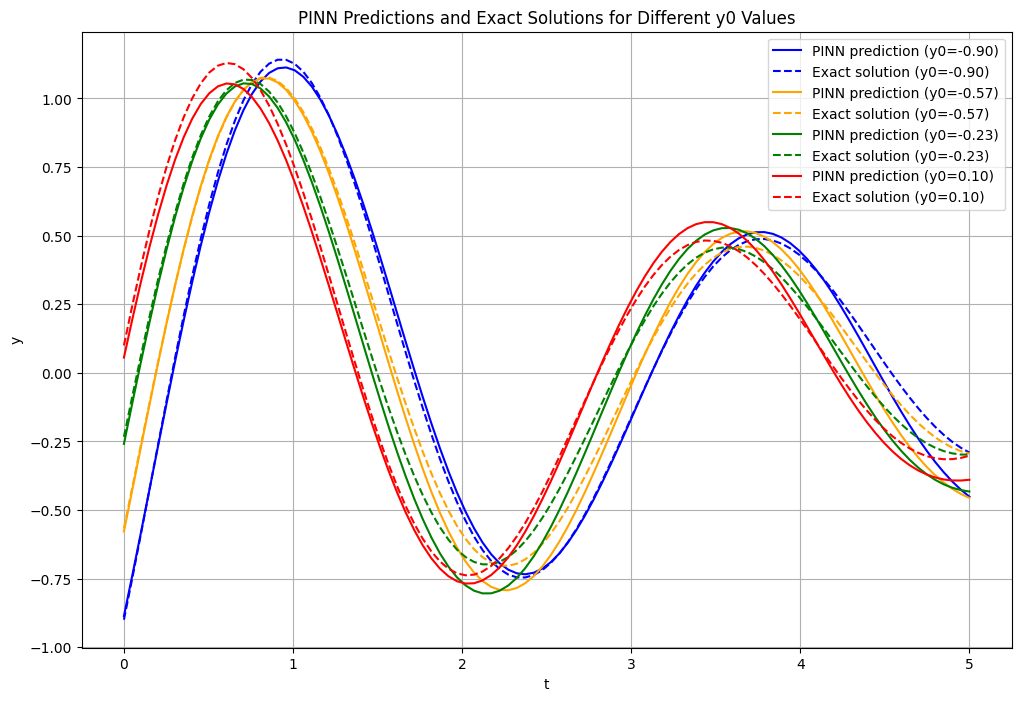


m_mu_y0_500_norm_4001
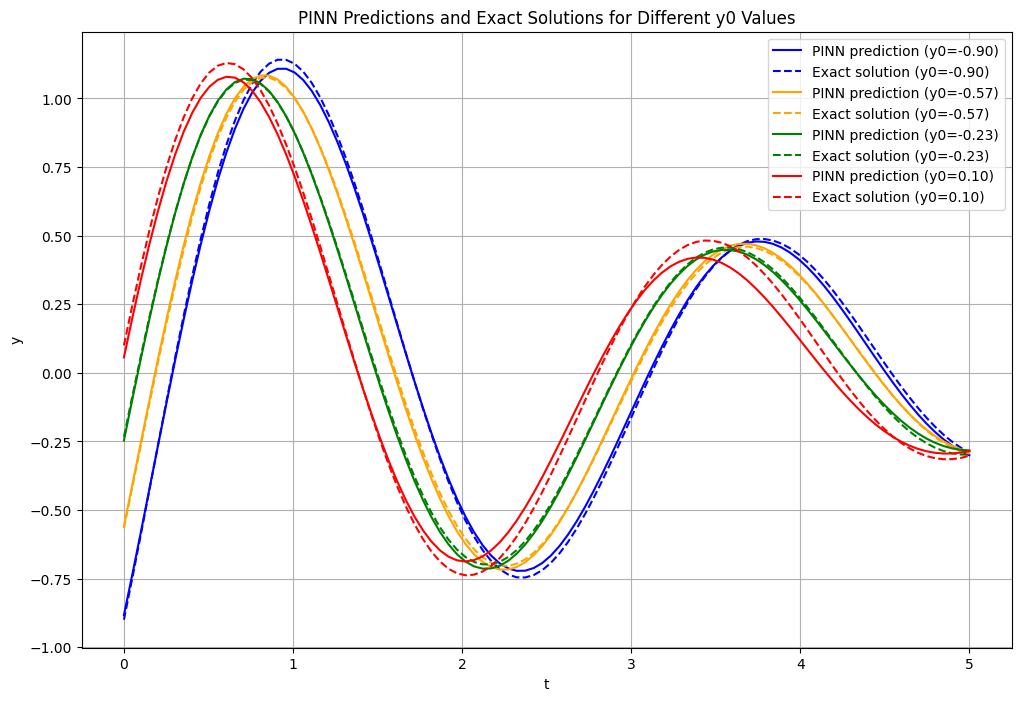 -->

<!-- m_mu_k_y0_500_norm_4001
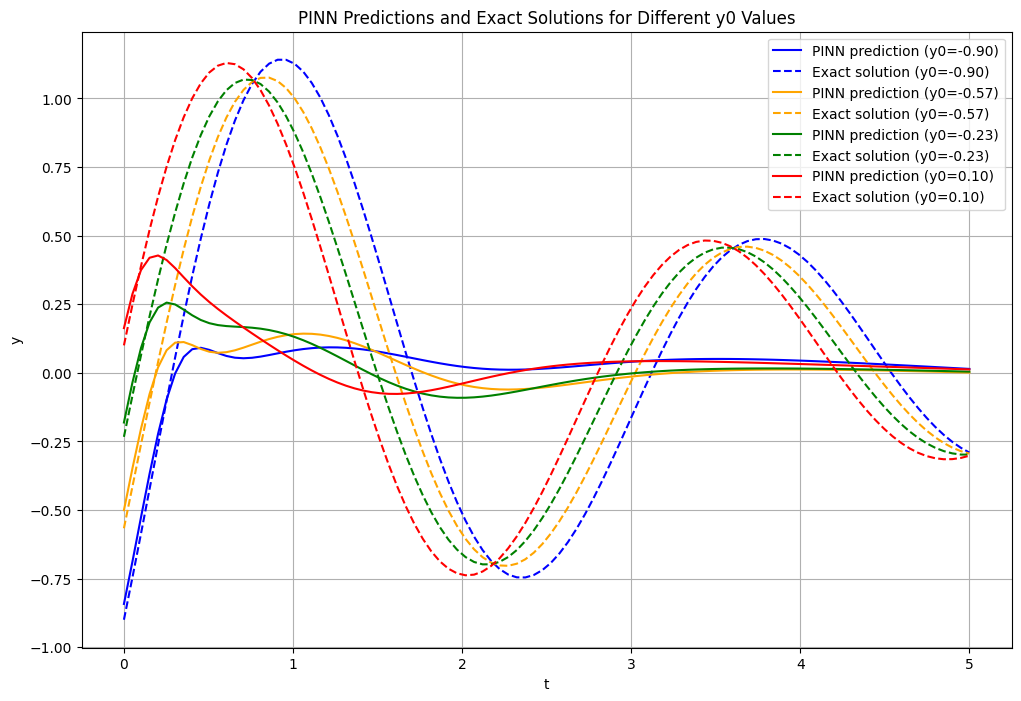

m_mu_k_y0_500_norm_notT_4001
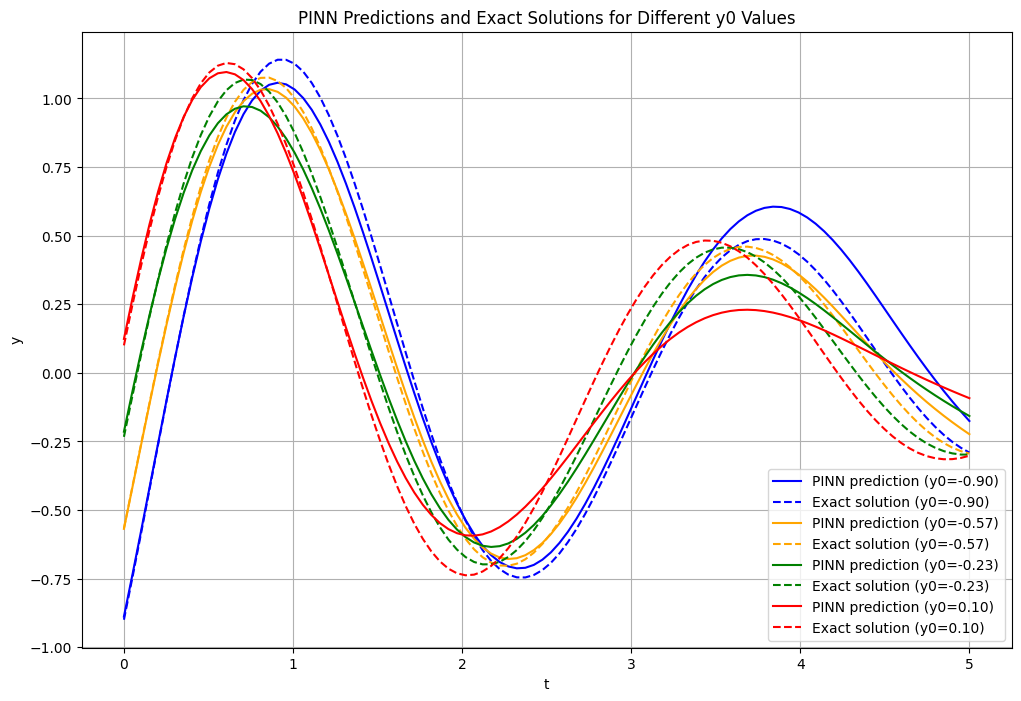

m_mu_k_y0_v0_500_norm_notT_4001
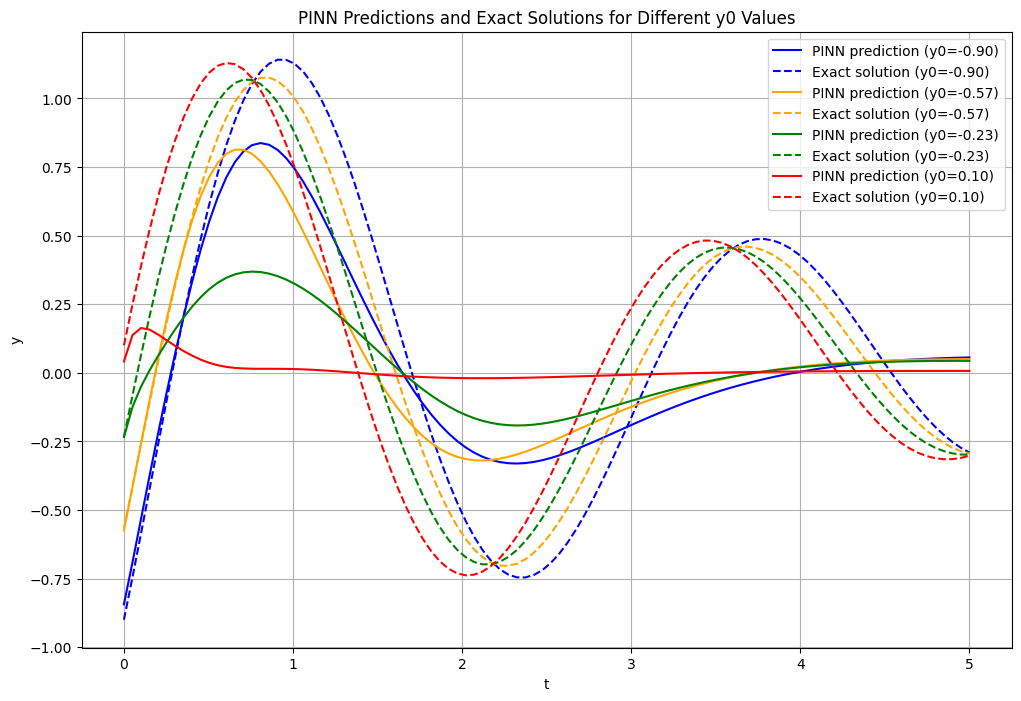 -->

In [11]:
import itertools
def combo_evaluation(PINN_model, specs, distribute):
    """
    Evaluate the PINN model for a combination of distributed parameters.
    """
    combo_values = {}
    mean_values = {}
    for param in ['m', 'mu', 'k', 'y0', 'v0']:
        spec = specs[param]
        mean = spec['mean']
        std = spec['std']
        lower = mean + spec['lower_multiplier'] * std
        upper = mean + spec['upper_multiplier'] * std
        
        if param in distribute:
            combo_value = np.linspace(lower, upper,6) 
            combo_values[param] = combo_value
        else:
            # Use a constant value for non-distributed parameters.
            mean_value = np.array([[mean]])
            mean_values[param] = mean_value

    errors = []
    combos = list(itertools.product(*combo_values.values()))
    print(f"Number of combinations: {len(combos)}")
    for combo in combos:
        input_values =[]
        i=0
        for param in ['m', 'mu', 'k', 'y0', 'v0']:
            if param in distribute:
                input_values.append(combo[i])
                i+=1
            else:
                input_values.append(mean_values[param].item())  
        test_params = make_input_params(t_coll,input_values, params['norm_info'])
        # Get the PINN prediction
        y_pred = PINN_model(t_coll, *test_params)
        # Compute the exact solution
        y_exact = damped_harmonic_oscillator(t_test, *input_values)
        # Compute the mean squared error for this combination
        mse = np.mean((y_pred.detach().numpy().flatten() - y_exact)**2)
        errors.append(mse)

    combined_mse = np.mean(errors)
    return combined_mse

distribute=['m','mu']
combined_mse=combo_evaluation(PINN_model, specs, distribute)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")

Number of combinations: 36

Combined Mean Squared Error over all combinations: 0.003413


**all:**

all_5000_norm_4001_P2INN_10_4_10_3_20_6 : 0.010207

all_5000_norm_4001_P2INN_10_4_10_3_20_6: 0.001530

all_5000_norm_4001_vanilla: 0.001966  ## WHAT? 

all_5000_norm_4001_vanilla_newstds: 0.011611

**m_mu:**

m_mu_500_norm_4001: 0.003413 

m_mu_500_norm_8001: 0.000672



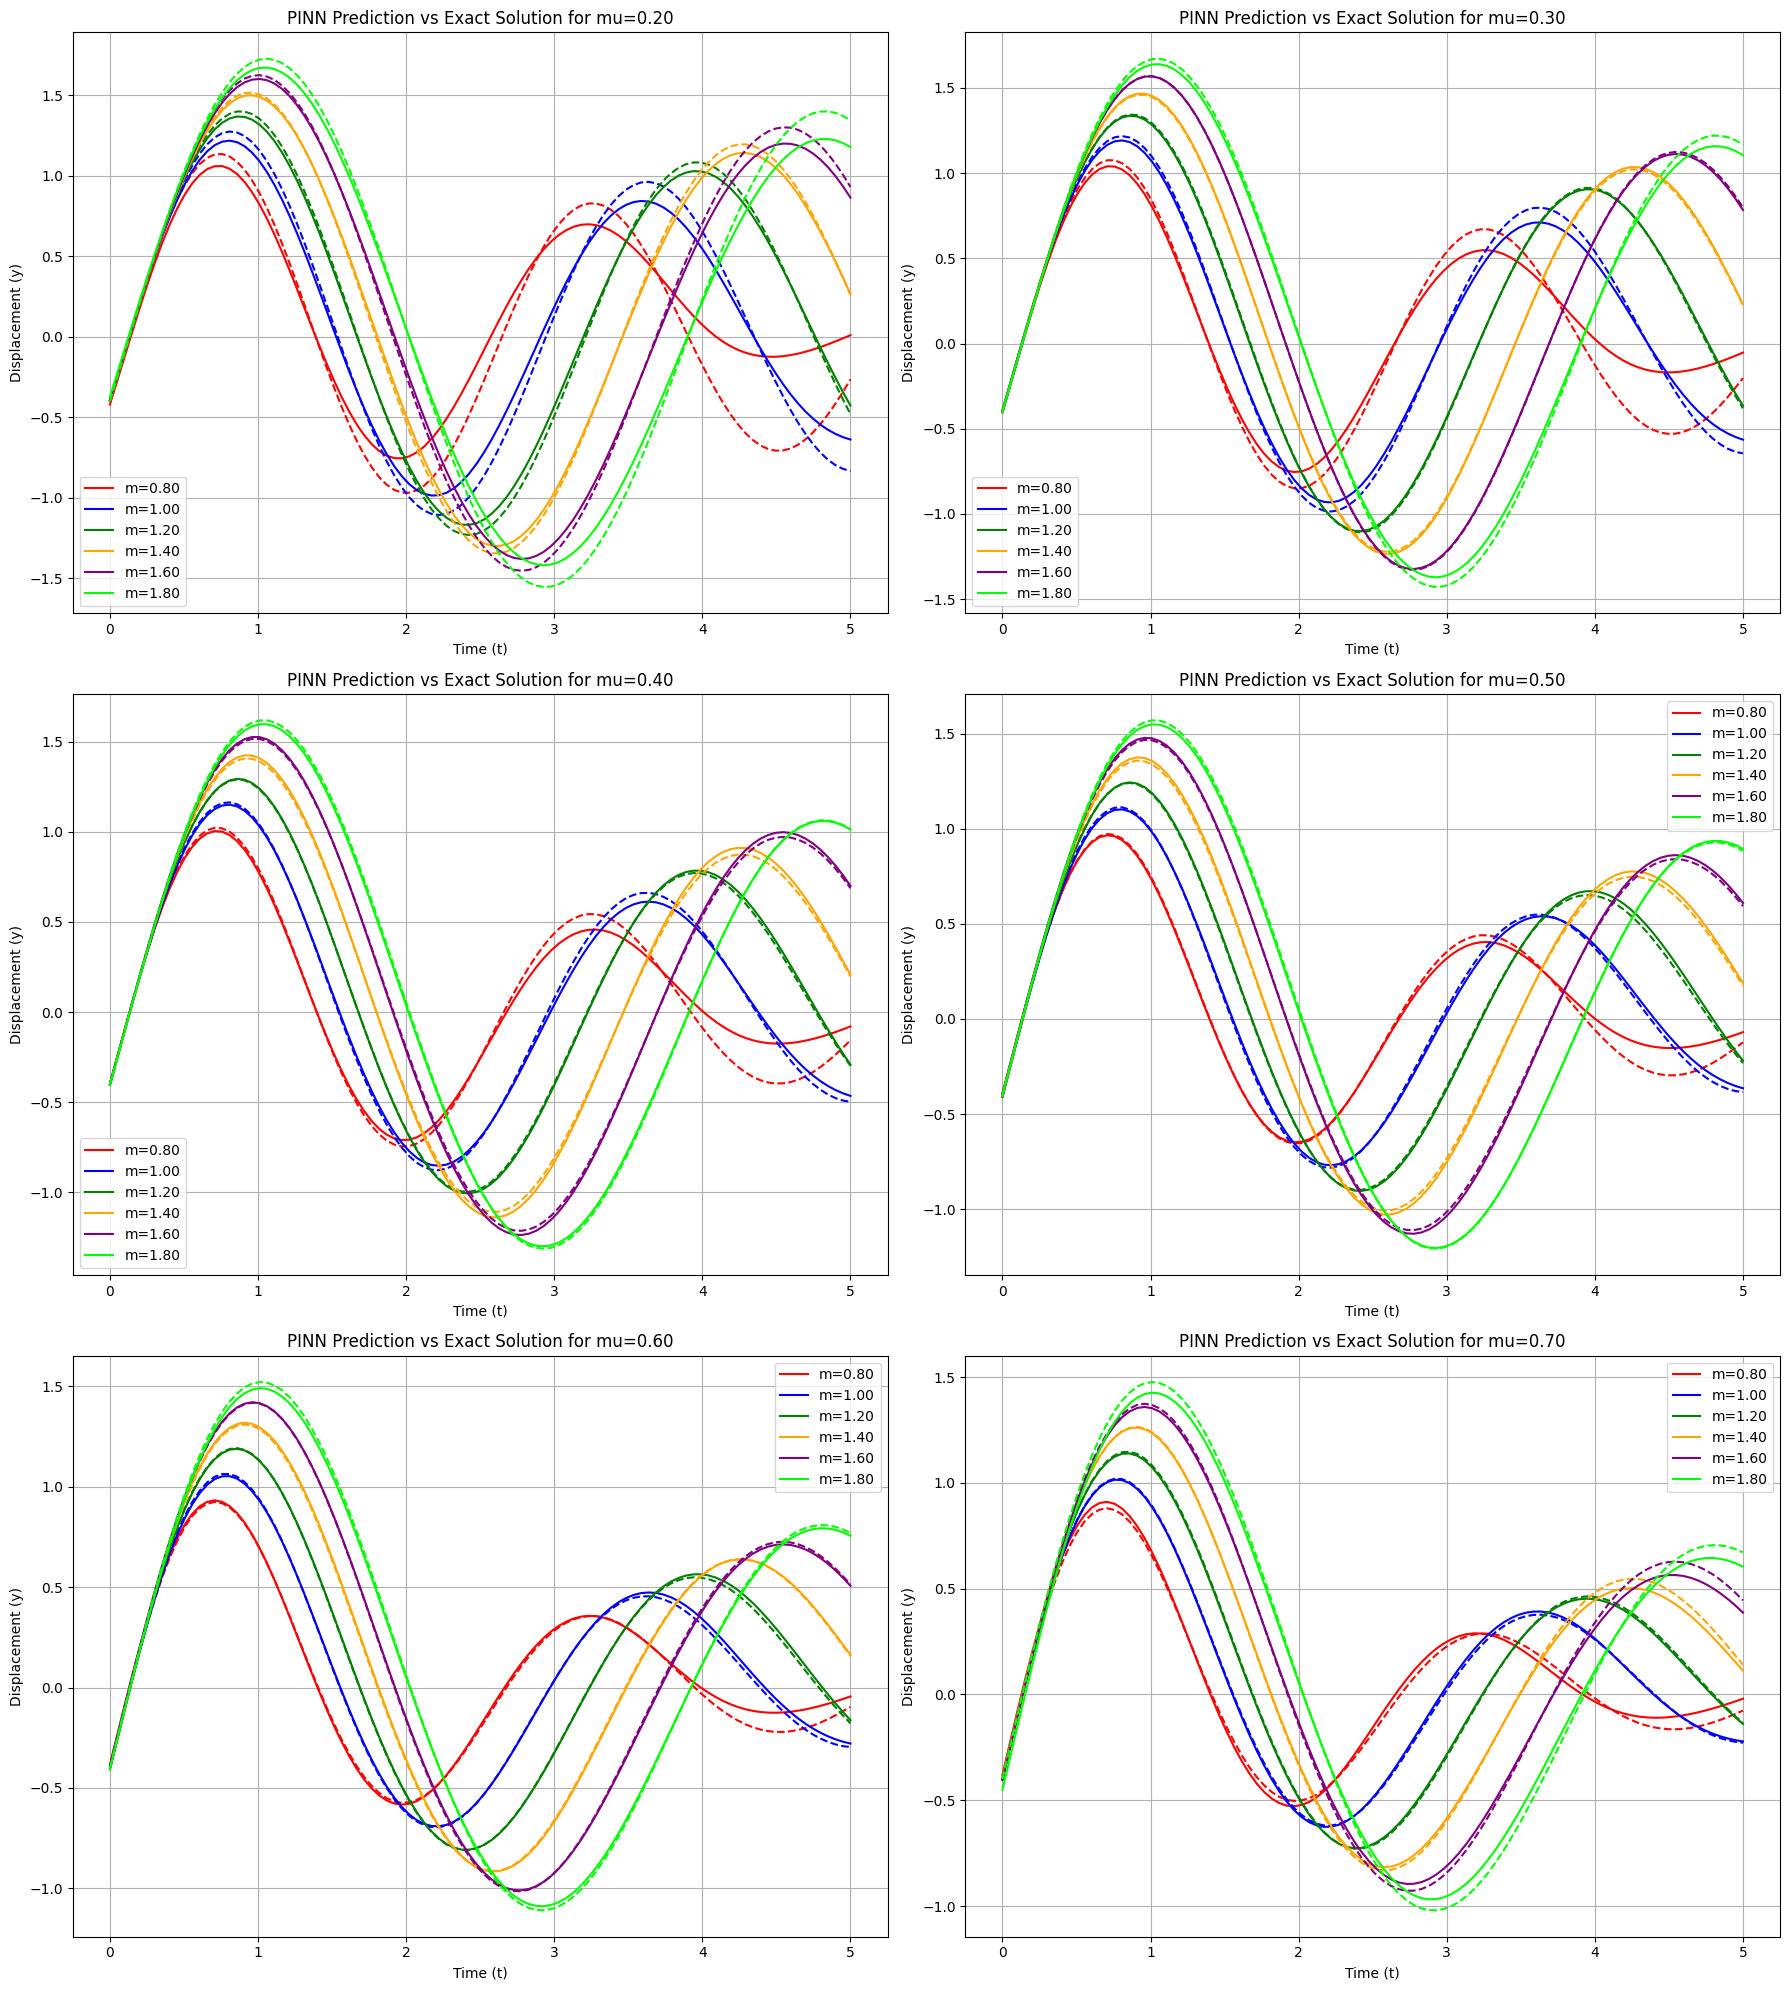

In [12]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan']
m_values = np.linspace(m_mean + specs['m']['lower_multiplier'] * m_std, 
                       m_mean + specs['m']['upper_multiplier'] * m_std, 6)
mu_values = np.linspace(mu_mean + specs['mu']['lower_multiplier'] * mu_std, 
                        mu_mean + specs['mu']['upper_multiplier'] * mu_std, 6)
v0_values = np.linspace(v0_mean + specs['v0']['lower_multiplier'] * v0_std, 
                        v0_mean + specs['v0']['upper_multiplier'] * v0_std, 6)

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, mu in zip(axes,mu_values):

    for idx, m in enumerate(m_values):
        test_values = [m, mu, k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_coll, test_values, params['norm_info'])
        
        # Get the PINN prediction
        y_pred = PINN_model(t_coll, *test_params)
        # Compute the exact solution using the provided function (convert t_test to numpy)
        y_exact = damped_harmonic_oscillator(t_test, 
                                             *test_values)
        
        ax.plot(t_test, y_pred.detach().numpy(), color=colors[idx], label=f'm={m:.2f}')
        ax.plot(t_test, y_exact, color=colors[idx], linestyle='--')

    ax.set_title(f'PINN Prediction vs Exact Solution for mu={mu:.2f}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Displacement (y)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

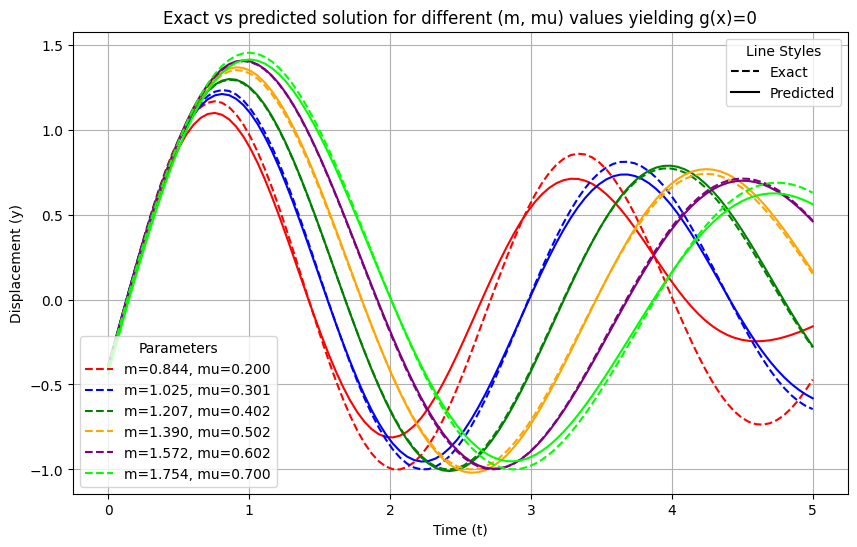


Combined Mean Squared Error over all 910 combinations: 0.002736


In [13]:
# g(x) = 0.0 for exact solution

from scipy.optimize import root_scalar

# Function to find mu for a given m where the exact solution is -1.0
def find_mu_g_equal_0(t,m,k, y0, v0, mu_bracket=(0.0, 2.0)):
    # Define the objective: we want the minimum of the solution to be -1
    def objective(mu):
        y_exact = damped_harmonic_oscillator(t, m=m, mu=mu, k=k, y0=y0, v0=v0)
        return np.min(y_exact) + 1.0  # When np.min(y_exact) == -1, this equals zero

    # Before starting, check that the bracket endpoints produce opposite signs
    a, b = mu_bracket
    if objective(a) * objective(b) > 0:
        raise ValueError("No sign change found in the objective function. Adjust mu_bracket values.")
    
    # Use the Brent's method (root_scalar with method='brentq') to find the root
    result = root_scalar(objective, bracket=mu_bracket, method='brentq')
    if result.converged:
        return result.root
    else:
        raise RuntimeError("Root finding did not converge.")

# Find mu values for each m
m_values = np.linspace(
    m_mean + specs['m']['lower_multiplier'] * m_std,
    m_mean + specs['m']['upper_multiplier'] * m_std,
    1000
)
mu_values = []

for m in m_values:
    mu_values.append(find_mu_g_equal_0(t_test, m, k_mean, y0_mean, v0_mean))

# Filter mu_values (and corresponding m_values) in one go:
filtered = [(m, mu) for m, mu in zip(m_values, mu_values)
            if specs['mu']['mean'] + specs['mu']['lower_multiplier'] * specs['mu']['std'] <= mu <= specs['mu']['mean'] + specs['mu']['upper_multiplier'] * specs['mu']['std']]

#Plott and compare the exact and predicted solutions for the filtered (m, mu) pairs
plt.figure(figsize=(10, 6))
idx=0
# Select five evenly distributed indices from the filtered list
selected_indices = np.linspace(0, len(filtered) - 1, 6, dtype=int)

for i in selected_indices:
    m, mu = filtered[i]
    color = colors[idx]  # Cycle through colors if idx exceeds length

    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_coll, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(t_coll, *pred_params)

    plt.plot(t_test, y_exact, label=f'm={m:.3f}, mu={mu:.3f}', linestyle='--', color=color)
    plt.plot(t_test, y_pred.detach().numpy(), color=color)

    idx += 1
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.title('Exact vs predicted solution for different (m, mu) values yielding g(x)=0')
plt.legend(loc='lower left')
plt.grid(True)

# Create dummy lines for the style legend
from matplotlib.lines import Line2D
line_exact = Line2D([0], [0], color='black', lw=1.5, linestyle='--')
line_pred = Line2D([0], [0], color='black', lw=1.5, linestyle='-')
# First legend for the (m, mu) labels
legend1 = plt.legend(loc='lower left', title='Parameters')
plt.gca().add_artist(legend1)
# Second legend for the line styles (exact vs predicted)
plt.legend([line_exact, line_pred], ['Exact', 'Predicted'], loc='upper right', title='Line Styles')

plt.show()

errors = []
for m,mu in filtered:
    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_mean, y0=y0_mean, v0=v0_mean)

    pred_params = make_input_params(t_coll, [m, mu, k_mean, y0_mean, v0_mean], params['norm_info'])
    y_pred = PINN_model(t_coll, *pred_params)

    mse = np.mean((y_pred.detach().numpy().flatten() - y_exact) ** 2)
    errors.append(mse)    
combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all {len(errors)} combinations: {combined_mse:.6f}")

### Adaptive sampling at g(x) = 0 

#### Sample new training points 

In [14]:
# Generate latin hypercube samples

from scipy.stats import qmc

def generate_latin_hypercube_samples(specs, norm_info, num_samples=1000):
    """
    Generate Latin Hypercube samples for parameters in specs that also is in params['norm_info].

    returns:
        - samples: A numpy array with a coloumn for each parameter in specs. 
        The params that are in norm_info are sampled, and the rest are set to their mean value.
        - params_to_sample: A list of the parameters that were sampled.
    """ 
    # Extract the number of samples and the parameters to sample from specs
    params_to_sample = [param for param in norm_info.keys() if param != 't']   #### Changed this without testing if it works #####
    
    # Create a Latin Hypercube sampler
    sampler = qmc.LatinHypercube(len(params_to_sample))
    samples = sampler.random(num_samples)
    
    # Scale the samples to the ranges defined in specs
    scaled_samples = []
    i = 0
    for param in specs.keys():
        if param == 't':
            continue
        if param in params_to_sample:
            lower_bound = specs[param]['mean'] + specs[param]['lower_multiplier'] * specs[param]['std']
            upper_bound = specs[param]['mean'] + specs[param]['upper_multiplier'] * specs[param]['std']
            scaled_samples.append(qmc.scale(samples[:, i].reshape(-1, 1), lower_bound, upper_bound))
            i += 1
        else:
            # If the parameter is not in the specs, just use its mean value
            scaled_samples.append(np.full((num_samples, 1), specs[param]['mean']))
    return np.array(scaled_samples).T[0], params_to_sample

def generate_sobol_samples(specs, norm_info, num_samples=1000):
    """
    Generate Sobol samples for parameters in specs that also is in params['norm_info].

    returns:
        - samples: A numpy array with a coloumn for each parameter in specs. 
        The params that are in norm_info are sampled, and the rest are set to their mean value.
        - params_to_sample: A list of the parameters that were sampled.
    """ 
    # Extract the number of samples and the parameters to sample from specs
    params_to_sample = [param for param in specs.keys() if param in norm_info and param != 't']
    
    # Create a Sobol sampler
    sampler = qmc.Sobol(len(params_to_sample))
    samples = sampler.random(num_samples)
    
    # Scale the samples to the ranges defined in specs
    scaled_samples = []
    i = 0
    for param in specs.keys():
        if param == 't':
            continue
        if param in params_to_sample:
            lower_bound = specs[param]['mean'] + specs[param]['lower_multiplier'] * specs[param]['std']
            upper_bound = specs[param]['mean'] + specs[param]['upper_multiplier'] * specs[param]['std']
            scaled_samples.append(qmc.scale(samples[:, i].reshape(-1, 1), lower_bound, upper_bound))
            i += 1
        else:
            # If the parameter is not in the specs, just use its mean value
            scaled_samples.append(np.full((num_samples, 1), specs[param]['mean']))
    return np.array(scaled_samples).T[0], params_to_sample

In [15]:
def sample_G_and_residual_points(G_vals, residual_vals, samples, alpha_g=20, alpha_residual=0.5, g_size=300, residual_size=200):
    # Sample near g(x) ≈ 0
    G_weights = np.exp(-alpha_g * np.abs(G_vals)) 
    G_weights /= np.sum(G_weights)  # Normalize weights
    G_indices = np.random.choice(len(samples), size=g_size, p=G_weights, replace=False)
    G_points_selected = samples[G_indices]

    # Sample near large residuals
    residual_weights = residual_vals**alpha_residual
    residual_weights /= np.sum(residual_weights)  # Normalize weights
    residual_indices = np.random.choice(len(samples), size=residual_size, p=residual_weights, replace=False)
    residual_points_selected = samples[residual_indices]
    # stack residual and G points
    points_selected = np.vstack((G_points_selected, residual_points_selected))
    return points_selected, G_points_selected, residual_points_selected

In [16]:
def make_input_params_batched(t_coll, values, norm_info=None):
    """
    Makes batched test parameters for input to the PINN model.

    Args:
      t_test:  torch.Tensor of shape (Nt,) or array-like
      values:  torch.Tensor shape (5,), or (B,5)
      norm_info:  optional dict for z-score normalization
      device:     torch.device (defaults to t_test.device)

    Returns:
      Tuple of 5 torch.Tensors, each of shape (B, Nt, 1).
    """
    Nt = t_coll.shape[0]

    # If it’s 1D-length-5, make it shape (1,5)
    if values.dim() == 1:
        values = values.unsqueeze(0)

    B = values.shape[0]
    if values.shape[1] != 5:
        raise ValueError(f"Expected second dim of size 5, got {values.shape}")

    for i, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        # 3) (Optional) apply normalization in batch
        if norm_info and param in norm_info:
            # Example for each column; adapt your z_score_normalize to accept Tensors
            values[:, i] = z_score_normalize(values[:, i], norm_info[param])

    # 4) Expand each scalar to (B, Nt, 1)
    # values[:,i] is (B,)
    m  = values[:, 0][:, None, None].expand(B, Nt, 1)
    mu = values[:, 1][:, None, None].expand(B, Nt, 1)
    k  = values[:, 2][:, None, None].expand(B, Nt, 1)
    y0 = values[:, 3][:, None, None].expand(B, Nt, 1)
    v0 = values[:, 4][:, None, None].expand(B, Nt, 1)

    return m, mu, k, y0, v0

def limit_state_function_G_batched(
    model,
    t_batch,                # torch.Tensor, shape (Nt,)
    pred_params,      # tuple of (m, mu, k, y0, v0), each shape (B, Nt, 1)
):
    """
    Batched limit‐state: G = min_t y_pred + 1.0
    Returns a torch.Tensor of shape (B,)
    """
    # Unpack
    m, mu, k, y0, v0 = pred_params
    # Call the PINN once over the whole batch
    # y_pred: (B, Nt, 1)
    y_pred = model(t_batch, m, mu, k, y0, v0)
    # Squeeze off the last dim and min over time-axis
    # y_pred.squeeze(-1): (B, Nt)
    min_y, _ = torch.min(y_pred.squeeze(-1), dim=1)  # returns (values, indices)

    # G = min_y + 1.0  → shape (B,)
    return min_y + 1.0

def pde_loss_batched(model,
                     t, m, mu, k, y0_val, v0_val,
                     norm_info=None):
    """
    Batched PDE residual loss:
      residual = m*y_tt + mu*y_t + k*y
    Returns:
      mse_per_sample: torch.Tensor, shape (B,)
    """
    # 1) Forward pass

    y_pred = model(t, m, mu, k, y0_val, v0_val)       # (B, Nt, 1)
    # 2) Time-derivatives via autograd
    grad_ones = torch.ones_like(y_pred)
    y_t_norm  = torch.autograd.grad(y_pred, t, grad_outputs=grad_ones,
                                    create_graph=True)[0]
    y_tt_norm = torch.autograd.grad(y_t_norm, t, grad_outputs=grad_ones,
                                    create_graph=True)[0]

    # 3) Chain-rule if normalized time
    if norm_info is not None:
        dt_scale = norm_info['t']['range']
        y_t  = y_t_norm  / dt_scale
        y_tt = y_tt_norm / (dt_scale**2)
    else:
        y_t, y_tt = y_t_norm, y_tt_norm

    # 4) Denormalize parameters (we grab the first time-slice since params are constant in t)
    #    and reshape back so we can broadcast
    def denorm_and_expand(param, key):
        # param: (B, Nt, 1) → take param[:,0,0] → denorm → (B,) → (B,1,1)
        vals = param[:, 0, 0]
        if norm_info is not None and key in norm_info:
            vals = z_score_denormalize(vals, norm_info[key])
        return vals.view(-1, 1, 1)

    m_phys  = denorm_and_expand(m,  'm')
    mu_phys = denorm_and_expand(mu, 'mu')
    k_phys  = denorm_and_expand(k,  'k')

    # 5) Compute residual and MSE per sample
    residual = m_phys * y_tt + mu_phys * y_t + k_phys * y_pred  # (B, Nt,1)
    mse_per_sample = (residual**2).mean(dim=(1,2))               # (B,)
    return mse_per_sample

def boundary_loss_batched(model,
                          t0,          # torch.Tensor, shape (B, 1, 1), requires_grad=True
                          m, mu, k,
                          y0, v0,
                          norm_info=None):
    """
    Batched boundary loss at t=0:
      loss = (y_pred - y0_phys)^2 + (y_t - v0_phys)^2
    Returns:
      mse_per_sample: torch.Tensor, shape (B,)
    """
    # 1) Forward & derivative at initial time
    y_pred = model(t0, m, mu, k, y0, v0)                   # (B,1,1)
    grad_ones = torch.ones_like(y_pred)
    y_t_norm = torch.autograd.grad(y_pred, t0,
                                   grad_outputs=grad_ones,
                                   create_graph=True)[0]       # (B,1,1)

    # 2) Chain-rule if normalized time
    if norm_info is not None:
        dt_scale = norm_info['t']['range']
        y_t = y_t_norm / dt_scale
    else:
        y_t = y_t_norm

    # 3) Denormalize y0 and v0 (they’re constant over t0)
    y0_phys = y0[:, 0, 0]
    v0_phys = v0[:, 0, 0]
    if norm_info is not None:
        y0_phys = z_score_denormalize(y0_phys, norm_info['y0']) if 'y0' in norm_info else y0_phys
        v0_phys = z_score_denormalize(v0_phys, norm_info['v0']) if 'v0' in norm_info else v0_phys

    # 4) reshape to broadcast back to (B,1,1)
    y0_phys = y0_phys.view(-1,1,1)
    v0_phys = v0_phys.view(-1,1,1)

    # 5) compute per‐sample squared error and mean
    err = (y_pred - y0_phys)**2 + (y_t - v0_phys)**2  # (B,1,1)
    mse_per_sample = err.mean(dim=(1,2))              # (B,)

    return mse_per_sample

def evaluate_G_and_residual_batchwise(
    PINN_model,
    samples,        # (N,5) float32 tensor
    t_coll,         # (Nt,) float32 tensor
    norm_info,         # your dict with norm_info
    lambda_bc=2.0,
    batch_size=64):
    
    Nt = t_coll.shape[0]
    N = samples.shape[0]
    G_outs = np.empty(N, dtype=np.float32)
    R_outs = np.empty(N, dtype=np.float32)
    
    t0 = torch.zeros_like(t_coll)
    

    for start in range(0, N, batch_size):
        end = min(start + batch_size,N)
        batch_params = samples[start:end] # (B,5)

        B_cur=batch_params.shape[0]

        t_batch=t_coll.view(1, Nt, 1).expand(B_cur, Nt, 1)  # (B, Nt, 1)
        t0_batch=t0.view(1, Nt, 1).expand(B_cur, Nt, 1)  # (B, Nt, 1)
        
        # ---- limit_state_function_G batching ----
        # split into per-parameter tensors
        # m_b, mu_b, k_b, y0_b, v0_b = torch.unbind(batch_params, dim=1)
        
        # make_input_params must handle 1D-per-param -> (B, Nt, 1) or similar
        # Here we assume it will repeat each scalar over t_coll internally
        input_params = make_input_params_batched(
            t_coll,      # the same t_coll
            batch_params,
            norm_info
        )

        # G_vals: returns (B,) tensor
        with torch.no_grad():
            Gb = limit_state_function_G_batched(
                PINN_model,
                t_batch,
                input_params, 
            )  # -> shape (B,)

        # ---- PDE & boundary residuals batching ----

        pde_b = pde_loss_batched(
            PINN_model,
            t_batch.requires_grad_(True),
            *input_params,
            norm_info=params['norm_info']
        ) 
        
        bc_b = boundary_loss_batched(
            PINN_model,
            t0_batch.requires_grad_(True),
            *input_params,
            norm_info=params['norm_info']
        )
        
        Rb = pde_b + lambda_bc * bc_b
        
        G_outs[start:end] = Gb.numpy()
        R_outs[start:end] = Rb.detach().numpy()

    return G_outs, R_outs

def evaluate_G_batchwise(
    PINN_model,
    samples,        # (N,5) float32 tensor
    t_coll,         # (Nt,) float32 tensor
    norm_info,         # your dict with norm_info
    batch_size=64):
    
    Nt = t_coll.shape[0]
    N = samples.shape[0]
    G_outs = np.empty(N, dtype=np.float32)
    
    for start in range(0, N, batch_size):
        end = min(start + batch_size,N)
        batch_params = samples[start:end] # (B,5)

        B_cur=batch_params.shape[0]

        t_batch=t_coll.view(1, Nt, 1).expand(B_cur, Nt, 1)  # (B, Nt, 1)
        
        # ---- limit_state_function_G batching ----
        # split into per-parameter tensors
        # m_b, mu_b, k_b, y0_b, v0_b = torch.unbind(batch_params, dim=1)
        
        # make_input_params must handle 1D-per-param -> (B, Nt, 1) or similar
        # Here we assume it will repeat each scalar over t_coll internally
        input_params = make_input_params_batched(
            t_coll,      # the same t_coll
            batch_params,
            norm_info
        )

        # G_vals: returns (B,) tensor
        with torch.no_grad():
            Gb = limit_state_function_G_batched(
                PINN_model,
                t_batch,
                input_params, 
            )  # -> shape (B,)

        G_outs[start:end] = Gb.numpy()
    
    return G_outs

How the paper (Importance Sampling for PINNs) actually chooses points After identifying interesting regions (via DWT or another metric), the actual point selection is done using a weighted probability distribution over the sample pool: “We compute the sampling probability for each point using a normalized score... and sample points with probability proportional to that score.” Importance sampling for… In other words: Start with a pool of points (e.g. from LHS or uniformly sampled). Assign each point a score, like: Residual (if training a PINN), Gradient magnitude, Or your custom criterion (e.g. 𝜙(𝑥)=exp(−𝛼∣𝑔(𝑥)∣), to favor points near 𝑔=0).


In [17]:
# import numpy as np

# def sample_time_points(T, N, r):
#     """
#     Sample N time points from a truncated exponential distribution over [0, T].

#     Parameters:
#     - T: Total time duration.
#     - N: Number of time points to sample.
#     - r: Rate parameter of the exponential distribution.

#     Returns:
#     - Array of sampled time points.
#     """
#     if r == 0:
#         # Uniform sampling
#         return np.linspace(0, T, N)
#     else:
#         # Inverse transform sampling
#         u = np.random.uniform(0, 1, N)
#         return -np.log(1 - u * (1 - np.exp(-r * T))) / r

# https://arxiv.org/abs/2404.18780

#### 3.

In [18]:
def generate_normal_samples(specs, norm_info, num_samples=1000):
    """
    Generate samples for parameters in specs that follow the normal distributions 
    defined in norm_info and specs.

    returns:
        - samples: A numpy array with a column for each parameter in specs. 
                  The params that are in norm_info are sampled from normal distributions,
                  and the rest are set to their mean value.
        - params_to_sample: A list of the parameters that were sampled.
    """ 
    # Extract the parameters that need to be sampled based on norm_info
    params_to_sample = [param for param in specs.keys() if param in norm_info and param != 't']
    
    # Initialize a list to hold the sampled values
    sampled_params = []

    for param in specs.keys():
        if param == 't':
            continue
        
        if param in params_to_sample:
            # For sampled parameters, use normal distribution
            mean = specs[param]['mean']
            std = specs[param]['std']
            samples = np.random.normal(mean, std, num_samples)
            
            # # Optionally, clip the samples to ensure they fall within a reasonable range
            # # You can adjust these ranges or skip clipping depending on your problem's needs
            # lower_bound = mean + specs[param].get('lower_multiplier', -np.inf) * std
            # upper_bound = mean + specs[param].get('upper_multiplier', np.inf) * std
            # samples = np.clip(samples, lower_bound, upper_bound)
            
            sampled_params.append(samples)
        else:
            # If parameter isn't being sampled, set to its mean value
            sampled_params.append(np.full((num_samples,), specs[param]['mean']))

    # Convert to numpy array for easier manipulation
    samples_array = np.array(sampled_params).T
    
    return samples_array, params_to_sample

In [19]:
def pdf_value(values, norm_info):
    """Input:
    - values:  (N,5) array of not normalized parameter values
    - specs:   dict with specs for each parameter"""
    """Output:
    - pdf:  (N,) array of pdf values for each combination of parameters"""
    norm_info_cop = norm_info.copy()
    norm_info_cop.pop('t', None)
    pdf = np.ones(values.shape[0])
    for i, param in enumerate(norm_info_cop.keys()):
        mean = norm_info_cop[param]['mean']
        std = norm_info_cop[param]['std']
        pdf *= norm.pdf(values[:, i], loc=mean, scale=std)
    return pdf

In [20]:
def initial_MCMC_samples(specs, norm_info, num_initial_samples=10):
    lhs_sampler = qmc.LatinHypercube(len(norm_info)-1)  # -1 because 't' is not sampled
    initial_lhs = lhs_sampler.random(num_initial_samples)
    initial_samples= np.zeros((num_initial_samples, 5))
    j=0
    for i, param in enumerate([key for key in specs.keys() if key != 't']):
        if param in norm_info:
            mean = specs[param]['mean']
            std = specs[param]['std']
            lower_bound = mean + specs[param]['lower_multiplier'] * std
            upper_bound = mean + specs[param]['upper_multiplier'] * std
            initial_samples[:, i] = initial_lhs[:, j] * (upper_bound - lower_bound) + lower_bound
            j += 1
        else:
            # If the parameter is not in the specs, just use its mean value
            initial_samples[:, i] = np.full((num_initial_samples,), specs[param]['mean'])

    return(initial_samples)

In [21]:
def metropolis_hastings(t_coll, num_samples, burn_in, num_initial_samples, norm_info, specs, proposal_scale = 1):

    u_curr = initial_MCMC_samples(specs, norm_info, num_initial_samples)
    u_prop = np.copy(u_curr)
    accepted_count = 0
    t_batch=t_coll.view(1, t_coll.shape[0], 1).expand(u_prop.shape[0], t_coll.shape[0], 1)  # (B, Nt, 1)
    sigma_hat_e = 0.01 * np.std(u_curr)   # Initial guess - must be improved later 
    accepted_samples = np.zeros((num_samples, num_initial_samples, u_curr.shape[1]))

    for i in range(num_samples+burn_in):
        # Generate a new sample from the proposal distribution
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in norm_info:
                u_prop[:, j] = np.random.normal(loc=u_curr[:, j], scale=proposal_scale*specs[param]['std'], size=u_curr.shape[0])

        # Evaluate the limit state function G(x) for the proposal sample
        input_to_g_prop = make_input_params_batched(t_coll, torch.from_numpy(u_prop).float(), norm_info)
        
        g_hat_prop = limit_state_function_G_batched(
            PINN_model,
            t_batch,
            input_to_g_prop
        ).detach() # detach() to avoid gradients = True 

        # Evaluate the limit state function G(x) for the current sample
        input_to_G_curr = make_input_params_batched(t_coll, torch.from_numpy(u_curr).float(), norm_info)

        g_hat_curr = limit_state_function_G_batched(
            PINN_model,
            t_batch,
            input_to_G_curr
        ).detach() # detach() to avoid gradients = True

        # Evaluate the pdf values for the current and proposal samples
        pdf_curr = pdf_value(u_curr, norm_info)
        pdf_prop = pdf_value(u_prop, norm_info)

        # Evaluate the pi-function for the proposal and current samples
        pi_prop= norm.cdf(-g_hat_prop/sigma_hat_e)
        pi_curr= norm.cdf(-g_hat_curr/sigma_hat_e)

        # Evaluate the h-function for the proposal and current samples
        h_prop = pi_prop * pdf_prop
        h_curr = pi_curr * pdf_curr

        alpha = h_prop / h_curr

        # Accept or reject the proposal based on the acceptance ratio
        rand = np.random.rand(num_initial_samples)
        accept = alpha > rand
        u_curr = np.where(accept[:, None], u_prop, u_curr)

        if i >= burn_in:
            accepted_count += np.sum(accept) # total number of accepted proposals, not stored samples
            accepted_samples[i - burn_in] = u_curr            

    return accepted_samples, accepted_count

In [22]:
accepted_samples, accepted_count = (metropolis_hastings(t_coll, 1000, 100, 2, params['norm_info'], specs, proposal_scale = 0.2))

In [23]:
from sklearn.cluster import KMeans

def select_cluster_centers(accepted_samples, n_clusters=30, random_state=0):
    """
    Flatten accepted MCMC samples and apply k-means to select Nc points.

    Parameters:
        accepted_samples (np.ndarray): shape (num_samples, num_chains, n_params)
        n_clusters (int): number of clusters (default 30)
        random_state (int): for reproducibility

    Returns:
        centers (np.ndarray): shape (n_clusters, n_params)
    """
    # Flatten the samples: shape (num_samples * num_chains, n_params)
    flattened_samples = accepted_samples.reshape(-1, accepted_samples.shape[-1])

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(flattened_samples)

    # Extract the cluster centers
    centers = kmeans.cluster_centers_

    return centers

In [25]:
kmeans_centers = select_cluster_centers(accepted_samples, n_clusters=30, random_state=0)

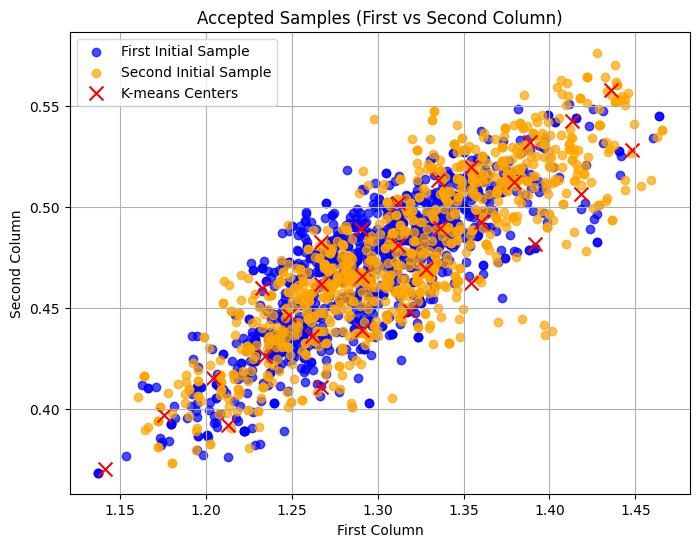

In [26]:
# Extract the first and second columns of accepted_samples
x_accepted = accepted_samples[:, :, 0]  # First column
y_accepted = accepted_samples[:, :, 1]  # Second column

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Plot for the first initial sample
plt.scatter(x_accepted[:, 0], y_accepted[:, 0], color='blue', label='First Initial Sample', alpha=0.7)

# Plot for the second initial sample
plt.scatter(x_accepted[:, 1], y_accepted[:, 1], color='orange', label='Second Initial Sample', alpha=0.7)

# Plot for the k-means cluster centers
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], color='red', label='K-means Centers', marker='x', s=100)

plt.title('Accepted Samples (First vs Second Column)')
plt.xlabel('First Column')
plt.ylabel('Second Column')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Evaluate the exact solution and PINN_model prediction for k_means_centers
def compare_g_exact_and_pred(PINN_model, t_coll, t_test, datapoints, norm_info):

    kmean_tensor = torch.from_numpy(datapoints).float()

    kmean_input = make_input_params_batched(t_coll, kmean_tensor, norm_info)

    t_batch = t_coll.view(1, t_coll.shape[0], 1).expand(kmean_tensor.shape[0], t_coll.shape[0], 1)  # (B, Nt, 1)
    
    kmean_g_pred = limit_state_function_G_batched(
        PINN_model,
        t_batch,
        kmean_input
    ).detach().numpy().tolist()

    kmean_g_exact = np.empty(datapoints.shape[0])
    kmean_all_y_exact = np.empty((datapoints.shape[0],t_test.shape[0]))
    for i in range(datapoints.shape[0]):
        y_exact = damped_harmonic_oscillator(t_test, *datapoints[i])
        g_exact = y_exact.min() + 1.0
        kmean_g_exact[i] = g_exact.item()
        kmean_all_y_exact[i] = y_exact
    # Convert lists to NumPy arrays for element-wise subtraction
    k_mean_g_exact_array = np.array(kmean_g_exact)
    k_mean_g_pred_array = np.array(kmean_g_pred)

    compare_g = np.column_stack((k_mean_g_exact_array, k_mean_g_pred_array, k_mean_g_exact_array - k_mean_g_pred_array))
    return(compare_g, kmean_all_y_exact)

In [31]:
N=100
t_coll = torch.linspace(0, 5, N).view(-1, 1) / specs['t']['range']
t_test = np.linspace(0, 5, N)

g_kmean, y_exact_kmean = compare_g_exact_and_pred(PINN_model, t_coll, t_test, kmeans_centers, params['norm_info'])
#root mean square error
sigma_hat_e = np.sqrt(np.mean(g_kmean[:, 1]**2))

pi_kmeans = norm.cdf(-g_kmean[:, 1]/sigma_hat_e)   # Should I use the true value or the predicted value?
# Indicator: 1 if true g <= 0, else 0
I_kmeans_exact = (g_kmean[:, 0] <= 0).astype(float)

alpha_c_hat = np.mean(I_kmeans_exact/pi_kmeans)

# variance of alpha_c_hat with updated values of pi
delta_alpha_squared  = 1 / (len(g_kmean) - 1) * (np.mean((I_kmeans_exact**2) / (pi_kmeans**2)) - alpha_c_hat**2)

print(f"Estimated sigma_hat_e: {sigma_hat_e:.6f}")
print(f"Estimated alpha_c_hat: {alpha_c_hat:.6f}")
print(f"Variance of alpha_c_hat: {delta_alpha_squared:.6f}")

Estimated sigma_hat_e: 0.023489
Estimated alpha_c_hat: 0.292503
Variance of alpha_c_hat: 0.008153


In [32]:
print("pi values (mean):", np.mean(pi_kmeans))
print("number of actual failures:", np.sum(I_kmeans_exact))
print("correction factor alpha_c_hat:", alpha_c_hat)
print(g_kmean[:,0]<=0, g_kmean[:,1] <=0)

pi values (mean): 0.5135791890672129
number of actual failures: 8.0
correction factor alpha_c_hat: 0.2925027673861618
[False False False False False False False False False False False  True
 False False  True False False  True False False  True False False  True
 False False False  True  True  True] [False  True  True False  True False False False  True False False  True
 False False  True False False  True False False  True  True False  True
  True False False  True  True  True]


#### 4.

In [33]:
num_samples = int(500/10e-4)
print(num_samples)
norm_samples, sampled_params = generate_normal_samples(specs, params['norm_info'], num_samples)
print(sampled_params)

# 1. turn your (10000, 5) NumPy array into a float32 Torch tensor
norm_samples_tensor = torch.from_numpy(norm_samples).float()

500000
['m', 'mu']


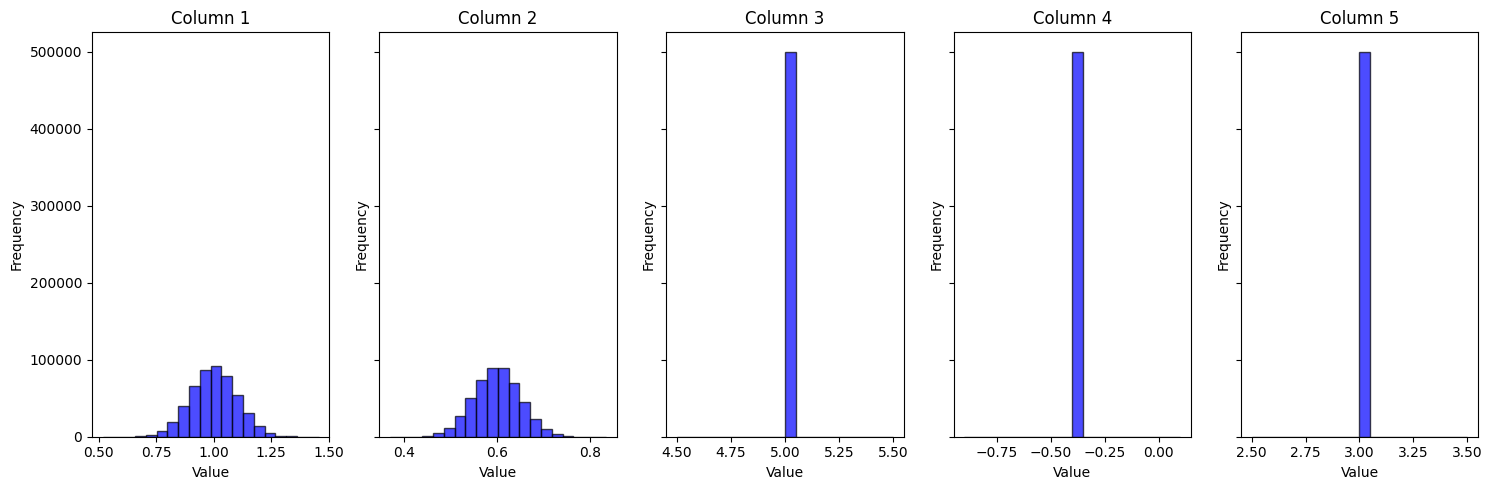

In [34]:
# Number of columns in norm_samples
num_columns = norm_samples.shape[1]

# Create subplots for each column
fig, axes = plt.subplots(1, num_columns, figsize=(15, 5), sharey=True)

for i in range(num_columns):
    axes[i].hist(norm_samples[:, i], bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f'Column {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
g_pred = evaluate_G_batchwise(
    PINN_model,
    norm_samples_tensor,
    t_coll,
    params['norm_info'],
    batch_size=64
)

In [36]:
print(g_pred.shape)
print(g_pred[:10])

(500000,)
[0.24379998 0.40289396 0.32883638 0.38165343 0.3193456  0.30003536
 0.374031   0.20799702 0.17050427 0.33110857]


In [37]:
pi_values= norm.cdf(-g_pred/sigma_hat_e)
P_hat_Fe = np.mean(pi_values)
print(f"Estimated probability of failure: {P_hat_Fe:.6f}")

#Variance of P_hat_Fe
delta_P_Fe_squared = 1 / (len(g_pred) - 1) * (np.mean((pi_values**2)) - P_hat_Fe**2)
print(f"Variance of P_hat_Fe: {delta_P_Fe_squared:.12f}")

Estimated probability of failure: 0.000065
Variance of P_hat_Fe: 0.000000000057


#### 5.

In [38]:
# Total failure probability
P_F_hat = alpha_c_hat * P_hat_Fe
# Estimate the variance
delta_P_F_squared = delta_alpha_squared * delta_P_Fe_squared
# Coefficient of variation
CoV_P_F_hat = np.sqrt(delta_P_F_squared) / P_F_hat

print(f"Estimated total failure probability: {P_F_hat:.4e}")
print(f"Variance of total failure probability: {delta_P_F_squared:.4e}")
print(f"Coefficient of variation of total failure probability: {CoV_P_F_hat:.4e}")

Estimated total failure probability: 1.8912e-05
Variance of total failure probability: 4.6309e-13
Coefficient of variation of total failure probability: 3.5983e-02


#### 6.

In [39]:
# Check convergence- if not converged, continoue training the PINN model
if CoV_P_F_hat > 0.01:
    print("Convergence not achieved, continue training the PINN model.")
else:
    print("Convergence achieved, stop training the PINN model.")

Convergence not achieved, continue training the PINN model.


#### 7.

In [42]:
# Include the evasluation of exact solutions into the loss 
def data_loss(PINN_model, datapoints, y_exact_datapoints, norm_info, lambda_data=1.0):
    """
    Compute the data loss for the PINN model.

    Args:
        PINN_model: The PINN model.
        datapoints: The centers of the clusters.
        y_exact_datapoints: The exact solutions at the cluster centers. (numpy)
        lambda_data: The weight for the data loss.

    Returns:
        The data loss value scaled by lambda_data.
    """
    timepoints = torch.linspace(0, 1, len(y_exact_datapoints[0])).view(-1, 1)

    # Compute the predicted values at the cluster centers
    pred_params = make_input_params_batched(timepoints, torch.from_numpy(datapoints).float(), norm_info)

    t_batch = timepoints.view(1, timepoints.shape[0], 1).expand(y_exact_datapoints.shape[0], timepoints.shape[0], 1)  # (B, Nt, 1)

    y_pred = PINN_model(t_batch, *pred_params).squeeze(-1)  # (B, Nt, 1) -> (B, Nt)

    # Reshape y_exact_datapoints to match y_pred
    y_exact_tensor = torch.from_numpy(y_exact_datapoints).float()

    # Compute the data loss
    data_loss_value = torch.mean((y_pred - y_exact_tensor)**2)
    return data_loss_value * lambda_data  

In [44]:
data_loss_value = data_loss(PINN_model, kmeans_centers, y_exact_kmean, params['norm_info'], lambda_data=1.0)
print(f"Data loss value: {data_loss_value.item():.6f}")

Data loss value: 0.000228


In [63]:
N=100
t_coll = torch.linspace(0, 5, N).view(-1, 1) / specs['t']['range']
t_test = np.linspace(0, 5, N)

# Generate samples
num_samples = 10000

LHS_samples, sampled_params = generate_latin_hypercube_samples(specs, params['norm_info'], num_samples)
# 1. turn your (10000, 5) NumPy array into a float32 Torch tensor
samples_tensor = torch.from_numpy(LHS_samples).float()
# 3. call the function
G_vals,R_vals = evaluate_G_and_residual_batchwise(
    PINN_model,
    samples_tensor,
    t_coll,
    params['norm_info'],
    lambda_bc=2.0,
    batch_size=128
)
# print(LHS_samples)
# print(G_vals)
# print(R_vals)

print(LHS_samples[0])
print(np.min(damped_harmonic_oscillator(t_test,*LHS_samples[0]))+1.0)
print(G_vals[0])
print(R_vals[0])

[ 1.57371721  0.25443145  5.         -0.4         3.        ]
-0.36924233552543106
-0.3381647
0.01870355


In [64]:
points_selected, G_points_selected, residual_points_selected = sample_G_and_residual_points(G_vals, R_vals, LHS_samples, alpha_g=20, alpha_residual=0.5, g_size=1000, residual_size=200)
print(points_selected[:10])

[[ 1.5459181   0.51592343  5.         -0.4         3.        ]
 [ 1.25781338  0.45445675  5.         -0.4         3.        ]
 [ 1.68121167  0.6458021   5.         -0.4         3.        ]
 [ 1.07956626  0.20592341  5.         -0.4         3.        ]
 [ 1.66512569  0.69401243  5.         -0.4         3.        ]
 [ 1.11496395  0.32280029  5.         -0.4         3.        ]
 [ 1.46882128  0.52548532  5.         -0.4         3.        ]
 [ 1.46204683  0.52785204  5.         -0.4         3.        ]
 [ 1.73772991  0.66389958  5.         -0.4         3.        ]
 [ 1.55618457  0.63380516  5.         -0.4         3.        ]]


Do I really need the residual here? I would have to try both, and see if adding high residual points actually helps. 

Also, I have not implemented a k_mean algorithm yet, since The points chosen looked quite wdespread already. Maybe I would need it if I use residual adaptive sampling with a high number for residul_vals**(Number). 

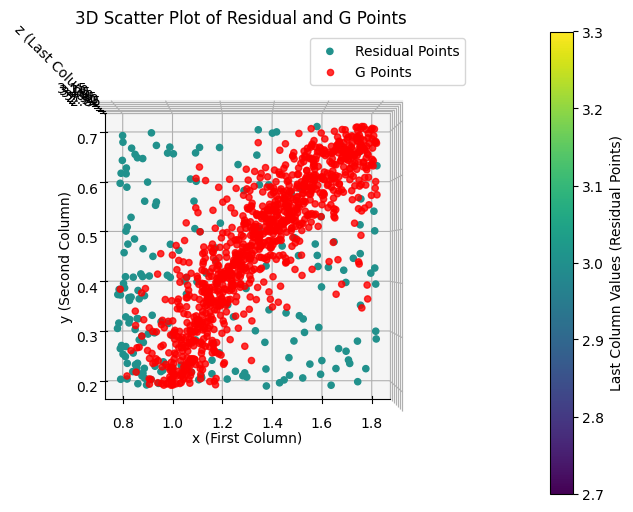

In [65]:
# Extract the first, second, and last columns of residual_points_selected for plotting
x_residual = residual_points_selected[:, 0]  # First column
y_residual = residual_points_selected[:, 1]  # Second column
z_residual = residual_points_selected[:, -1]  # Last column

# Extract the first, second, and last columns of G_points_selected for plotting
x_g = G_points_selected[:, 0]  # First column
y_g = G_points_selected[:, 1]  # Second column
z_g = G_points_selected[:, -1]  # Last column

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot residual_points_selected
scatter_residual = ax.scatter(x_residual, y_residual, z_residual, c=z_residual, cmap='viridis', label='Residual Points')

# Plot G_points_selected
scatter_g = ax.scatter(x_g, y_g, z_g, c='red', label='G Points', alpha=0.8)

# Add color bar for residual points
cbar = plt.colorbar(scatter_residual, ax=ax, pad=0.1)
cbar.set_label('Last Column Values (Residual Points)')

# Set labels and title
ax.set_title('3D Scatter Plot of Residual and G Points')
ax.set_xlabel('x (First Column)')
ax.set_ylabel('y (Second Column)')
ax.set_zlabel('z (Last Column)')

# Adjust the viewing angle
ax.view_init(elev=90, azim=-90)  # Change elevation and azimuth for a new angle

ax.legend()
plt.show()

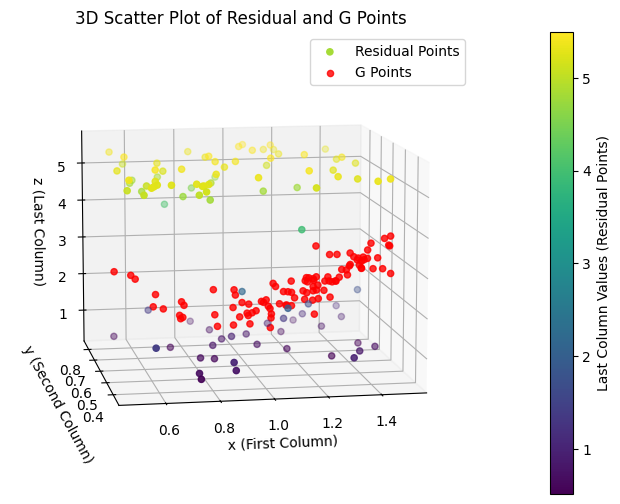
This piqture is good. It shows how it could be smart to narrow down the std search for paramter values. Here, sampling from v0 larger than 4 is not really necessary, since all the red points are below that. How do I implement that?

This adaptive refinement of paraeter space should be implemented, and this also goes for the physical space, and in my case time. No need to TRAIN THE pinn AFTER T=4 sek, but this is another impelemntation. 

Next training round 


In [66]:
print(params.keys())
print(params['t_coll'].shape)

def make_new_params(points_selected, specs, params):
    """
    Create new parameters for the PINN model based on selected points.

    Args:
        points_selected: A numpy array of shape (N, 5) with the selected points.
        specs: A dictionary containing the specifications for each parameter.
        params: A dictionary containing the current parameters.

    Returns:
        new_params: A dictionary with the new parameters for the PINN model.
    """
    # Create a copy of the original params to avoid modifying it directly
    new_params = params.copy()

    # Normalize the values in points_selected for the parameters in norm_info
    normalized_values = points_selected.copy()
    for i, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in params['norm_info']:
            mean = specs[param]['mean']
            std = specs[param]['std']
            normalized_values[:, i] = (points_selected[:, i] - mean) / std

    # Substitute the normalized values into new_params
    new_params['m'] = torch.tensor(normalized_values[:, 0], dtype=torch.float32).view(-1, 1)
    new_params['mu'] = torch.tensor(normalized_values[:, 1], dtype=torch.float32).view(-1, 1)
    new_params['k'] = torch.tensor(normalized_values[:, 2], dtype=torch.float32).view(-1, 1)
    new_params['y0'] = torch.tensor(normalized_values[:, 3], dtype=torch.float32).view(-1, 1)
    new_params['v0'] = torch.tensor(normalized_values[:, 4], dtype=torch.float32).view(-1, 1)
    # Create a new t_coll and t0 with the same length as the other values
    num_samples = normalized_values.shape[0]
    new_params['t_coll'] = torch.rand(num_samples, 1, dtype=torch.float32).requires_grad_(True)
    new_params['t0'] = torch.zeros(num_samples, 1, dtype=torch.float32).requires_grad_(True)
    new_params['norm_info'] = params['norm_info']  # Keep the normalization info

    return new_params

new_params= make_new_params(points_selected, specs, params)
print(new_params['m'].shape)
print(new_params.keys())
print(new_params['norm_info'])

dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
torch.Size([1000, 1])
torch.Size([1200, 1])
dict_keys(['t_coll', 'norm_info', 'm', 'mu', 'k', 'y0', 'v0', 't0'])
{'t': {'range': 5.0}, 'm': {'mean': 1.0, 'std': 0.1}, 'mu': {'mean': 0.6, 'std': 0.05}}


In [74]:
class Further_Trainer:
    def __init__(self, model, optimizer, epochs=4001, lambda_bc=10.0):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = lambda_bc

    def train(self, *args):
        # Allow passing a single dictionary argument, or individual tensors.
        if args and isinstance(args[0], dict):
            params = args[0]
            t_coll = params['t_coll']
            m_val  = params['m']
            mu_val = params['mu']
            k_val  = params['k']
            y0_val = params['y0']
            v0_val = params['v0']
            t0     = params['t0']
            # define the norm_info dictionary if it exists in params
            norm_info = params.get('norm_info', None)
        else:
            t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = args
            norm_info = None

        best_loss = float("inf")
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val, norm_info)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val, norm_info)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()

            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            current_loss = loss.item()
            if current_loss < best_loss:
                best_loss = current_loss

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)
                np.save("loss_history.npy", self.losses)
        print(f"Phase 1 complete. Best loss so far: {best_loss}")

        # Phase 2: Continue training until an epoch is reached with loss below the best_loss from Phase 1.
        extra_epochs = 0
        while True:
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val, norm_info)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val, norm_info)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()

            extra_epochs += 1
            epoch += 1
            current_loss = loss.item()
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())

            if extra_epochs % 1000 == 0:
                print(f"Extra Epoch {extra_epochs}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)
                np.save("loss_history.npy", self.losses)
            if current_loss < best_loss:
                print(f"Improved loss found: {current_loss} (after {extra_epochs} extra epochs)")
                plot_loss(range(epoch + 1), self.losses)
                np.save("loss_history.npy", self.losses)
                break
        

Epoch 0, PDE loss: 0.003688569413498044, BC loss: 3.142773493891582e-05


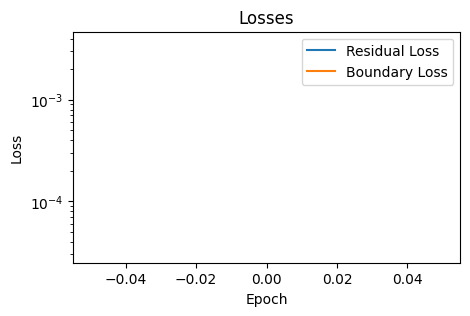

Phase 1 complete. Best loss so far: 0.004002846777439117
Improved loss found: 0.003983062691986561 (after 3 extra epochs)


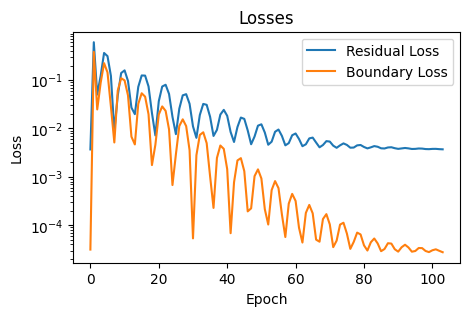

In [75]:
optimizer = optim.Adam(PINN_model.parameters(), lr=0.001)
trainer = Further_Trainer(PINN_model, optimizer,epochs=101)
trainer.train(new_params)

In [78]:
losses = np.load("loss_history.npy", allow_pickle=True).tolist() 
print(losses)

{'Residual Loss': [0.003688569413498044, 0.6059327721595764, 0.05017910152673721, 0.12165948003530502, 0.3632436990737915, 0.31288641691207886, 0.12198880314826965, 0.00881437212228775, 0.04776514321565628, 0.13982152938842773, 0.15878847241401672, 0.09566276520490646, 0.02698250114917755, 0.01977357268333435, 0.07247476279735565, 0.12457600980997086, 0.12377190589904785, 0.07393201440572739, 0.020860254764556885, 0.007174462545663118, 0.03663191944360733, 0.07366254180669785, 0.08003056794404984, 0.05164191499352455, 0.0174269899725914, 0.007635513320565224, 0.025704355910420418, 0.04832231625914574, 0.05115613341331482, 0.032352641224861145, 0.011049813590943813, 0.006405362393707037, 0.019027791917324066, 0.03214746341109276, 0.030797703191637993, 0.01743757352232933, 0.007003097329288721, 0.00935691874474287, 0.019373182207345963, 0.02422461099922657, 0.018277037888765335, 0.00845837127417326, 0.005259864963591099, 0.010699511505663395, 0.01680358126759529, 0.015780312940478325, 0.

### Finding MPP with scipy.optimize minimize

In [ ]:
from scipy.optimize import minimize
def MPP_objective(x,model,t, values, lambda_penalty, norm_info):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    all_values = list(x) + values
    pred_params = make_input_params(t, all_values, norm_info)
    lsf = limit_state_function_G(model, t, pred_params, differentiable=False)
    deviation=0
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            deviation+=(abs(x[i] - specs[param]['mean']) / specs[param]['std'])
    penalty = lambda_penalty * deviation

    return (abs(lsf) + penalty).item()
    
def find_MPP(model, t, values, norm_info, lamdba_penalty = 0.001):
    """
    Find the most probable point (MPP) using optimization.
    """
    MPP=[]
    x = []
    other_values = []
    for i,param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in norm_info:
            x.append(values[i])
        else:
            other_values.append(values[i])
    res = minimize(
        MPP_objective, 
        x, 
        args=(model, t, other_values, lamdba_penalty, norm_info), 
        method='Nelder-Mead'
        )
    if res.success:
        MPP.append(res.x)
    else:
        print(f"Start {i}: Optimization did not converge from initial guess {x}")
    return MPP

### Could also use jac and utlize autograd for the gradient
# def gradient(x, *args):
#     # must return a 1D array with same length as x
#     return ...


MPP_start = [m_mean, mu_mean, k_mean, y0_mean, v0_mean]

MPP = find_MPP(PINN_model, t_coll, MPP_start, params['norm_info'], lamdba_penalty=0.00001)
print(f"MPP: {MPP}")

#### Visualizing

In [ ]:
#Visualization of the MPP
mass_vals = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)

for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        Obj[i, j] = MPP_objective([Mass[i, j], Mu[i, j]], PINN_model, t_coll, [k_mean, y0_mean, v0_mean],
                                        lambda_penalty=0.0, norm_info=params['norm_info'])

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=50, cmap='viridis')
plt.colorbar(cp)
# plt.scatter([pt[0] for pt in MPP[0]], [pt[1] for pt in MPP[0]],
#             color='red', label='MPP')
plt.scatter(MPP[0][0].item() , MPP[0][1].item(), color='lime', label='Scipy minimize MPP', edgecolor='black')
plt.scatter(m_mean, mu_mean, color='red', label='Mean', edgecolor='black')
plt.legend()
plt.title('Objective Function Contour Plot')
plt.xlabel('Mass (m)')
plt.ylabel('Damping Ratio (mu)')
plt.grid()
plt.show()

### MPP brute force

#### PINN_model

In [ ]:
def normal_pdf(x, mean, std):
    """Compute 1D normal PDF."""
    return 1.0/(std*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/std)**2)

num_points = 200  # Increase if you need a finer grid

m_vals = np.linspace(m_mean +2*m_std, m_mean + 4*m_std, num_points)
mu_vals = np.linspace(mu_mean - 4*mu_std, mu_mean -2*mu_std , num_points)

m_grid, mu_grid = np.meshgrid(m_vals, mu_vals)

# Time vector for evaluating the solution
n_t = 1000
t_grid = torch.linspace(0, 1, n_t).view(-1, 1)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.0001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        test_values = [m_grid[j, i], mu_grid[j, i], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_grid, test_values, params['norm_info'])
        g_val = limit_state_function_G(PINN_model,t_grid, test_params, differentiable=False).item()
        G[j, i] = np.nan if g_val is None else g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = test_values[0]
                best_mu = test_values[1]
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.6f}\n"
          f"  mu = {best_mu:.6f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.310553
  mu = 0.464322
  g  = 0.000044   (should be close to 0)
  Joint PDF = 6.451544e-03

#### Analytical function

In [ ]:
# Time vector for evaluating the solution
t_max = 5.0
n_t = 1000
t_grid = np.linspace(0, t_max, n_t)

best_m = None
best_mu = None
best_pdf = 0.0
best_g = None  # The g(m, mu) value at the MPP

# Tolerance for "on the boundary"
tol = 0.001  # Adjust as needed for your "near 0" definition
# Evaluate g(m, mu) on grid
G = np.zeros((len(mu_vals), len(m_vals)))
for i,m in enumerate(m_vals):
    for j,mu in enumerate(mu_vals):
        g_val = damped_harmonic_oscillator(t_grid, m=m, mu=mu, k=5.0, y0=-0.4, v0=3.0).min() +1
        G[j, i] = g_val
        
        # Check if we are near the failure boundary g=0
        if abs(g_val) < tol:  # "Close" to zero
            # Joint PDF
            f_m = normal_pdf(m, m_mean, m_std)
            f_mu = normal_pdf(mu, mu_mean, mu_std)
            joint_pdf = f_m * f_mu
            
            # If this is highest so far, record it
            if joint_pdf > best_pdf:
                best_pdf = joint_pdf
                best_m = m
                best_mu = mu
                best_g = g_val

# Results
if best_m is None:
    print("No grid point near the failure boundary was found. Try increasing the range or tol.")
else:
    print(f"MPP found near boundary g(m,mu)=0 at:\n"
          f"  m  = {best_m:.4f}\n"
          f"  mu = {best_mu:.4f}\n"
          f"  g  = {best_g:.6f}   (should be close to 0)\n"
          f"  Joint PDF = {best_pdf:e}")


MPP found near boundary g(m,mu)=0 at:
  m  = 1.3106
  mu = 0.4601
  g  = 0.000997   (should be close to 0)
  Joint PDF = 5.107185e-03

### FORM

In [ ]:
# Step 0: initialize u (standard normal variables)
u = torch.tensor([0.0] * (len(params['norm_info'])-1), dtype=torch.float32, requires_grad=True) # '-1' because 't' is also in norm_info

for i in range(100):
    # Step 1: __________________________________
    values = []
    for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
        if param in params['norm_info']:
            values.append(u[j])
        else:
            values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

    t_FORM = torch.linspace(0, 1, 1000).view(-1, 1)
    input_params = tuple(v.expand(len(t_FORM), 1) for v in values)


    LSF= limit_state_function_G(PINN_model,t_FORM, input_params,differentiable=False)
    LSF.backward()

    # Extract gradient w.r.t. u
    grad_u = u.grad.detach().clone()  # ∇G/∇u
    norm_grad = torch.norm(grad_u)

    # Step 4: Compute update
    beta = LSF.item() / norm_grad.item()
    u_next = -beta * (grad_u / norm_grad)

    # Manually update u (we do it outside optimizer.step() to follow HL-RF logic)
    with torch.no_grad():
        u.copy_(u+u_next*0.2)
        # damping_factor = 0.6
        # u.copy_(u + damping_factor * (u_next - u))


    formatted_u_next = [f"{val:.4f}" for val in u_next.tolist()]
    formatted_u = [f"{val:.4f}" for val in u.tolist()]
    
    print(f'beta = {beta:.4f}')
    formatted_grad_u = [f"{val:.4f}" for val in grad_u.tolist()]
    print(f'grad_u = {formatted_grad_u}')
    print(f'norm_grad = {norm_grad:.4f}')
    print(f'LSF = {LSF.item()}')
    print(f'u_next = {formatted_u_next}')
    print(f'u = {formatted_u}')
    print('\n')
    u.grad.zero_()
    
print(f"∇G = {grad_u.tolist()}, ‖∇G‖ = {norm_grad:.4f}, β = {beta:.4f}")

beta = 0.0000
grad_u = ['-0.0565', '0.0496']
norm_grad = 0.0752
LSF = 0.0
u_next = ['0.0000', '-0.0000']
u = ['3.2879', '-2.5062']

In [ ]:
epsilon = 1e-3
finite_diff =[]
autograd_grad = []

start=-3
end=9
mu_test = 0

for i in np.linspace(start, end, 100):
    u_val = torch.tensor([i, mu_test], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)

    # Build a helper to compute G given a u vector:
    def compute_G(model, u_vector):
        values = []
        for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            if param in params['norm_info']:
                # Using the same transformation as in your code
                values.append(u_vector[j])
            else:
                values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        input_params = tuple(v.expand(len(t_FORM), 1) for v in values)
        return limit_state_function_G(model,t_FORM, input_params, differentiable=True)

    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()

    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

# Extract the first element of each list in finite_diff
finite_diff_first_elements = [fd[0] for fd in finite_diff]
# Extract the first element of each list in autograd_grad
autograd_grad_first_elements = [ag[0] for ag in autograd_grad]

# Plot the first element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_first_elements, label='Finite Difference (First Element)', color='blue')
plt.plot(np.linspace(start, end, 100), autograd_grad_first_elements, label='Autograd Gradient (First Element)', color='red', linestyle='--')
plt.xlabel('m')
plt.ylabel('Finite Difference (m)')
plt.title(f'dG/dm for mu = {mu_test} vs m')
plt.legend()
plt.grid()
plt.show()

finite_diff =[]
autograd_grad = []
norm_grad_list = []

start=-9
end=3
m_test = 0
for i in np.linspace(start, end, 100):
    u_val = torch.tensor([m_test, i], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
    fd_grad = torch.zeros_like(u_val)
    
    LSF = compute_G(PINN_model,u_val)
    LSF.backward()
    grad_u = u_val.grad.detach().clone()
    norm_grad = torch.norm(grad_u)
    norm_grad_list.append(norm_grad.item())
    for k in range(len(u_val)):
        u_plus = u_val.clone()
        u_minus = u_val.clone()
        u_plus[k] += epsilon
        u_minus[k] -= epsilon
        g_plus = compute_G(PINN_model,u_plus).item()
        g_minus = compute_G(PINN_model,u_minus).item()
        fd_grad[k] = (g_plus - g_minus) / (2 * epsilon)

    finite_diff.append(fd_grad.numpy())
    autograd_grad.append(grad_u.numpy())

finite_diff_second_elements = [fd[1] for fd in finite_diff]
autograd_grad_second_elements = [ag[1] for ag in autograd_grad]
print(norm_grad_list)
# Plot the second element of finite_diff against the linspace
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(start, end, 100), finite_diff_second_elements, label='Finite Difference (Second Element)', color='green')
plt.plot(np.linspace(start, end, 100), autograd_grad_second_elements, label='Autograd Gradient (Second Element)', color='orange', linestyle='--')
plt.xlabel('mu')
plt.ylabel('Finite Difference (mu)')
plt.title(f'dG/dmu for m = {m_test} vs mu')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 1. Wrap u again to ensure it's a fresh, tracked variable
u_FORM = u.detach().clone().requires_grad_(True)

# 2. Rebuild `values` list using u_final
values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        values.append(u_FORM[j])  # Adjusted for the damping factor
    else:
        values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# 3. Expand to match t
input_params = tuple(v.expand(len(t_FORM), 1) for v in values)

# 4. Re-evaluate G
G_final = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False)
print("Final G at converged u:", G_final)

In [ ]:
y_pred = PINN_model(t_FORM, *input_params)

plt.figure(figsize=(10, 6))
plt.plot(t_FORM, y_pred.detach().numpy(), label='PINN prediction')
# plt.plot(t_test.detach().numpy(), y_sol,label='Exact solution', linestyle='--')
plt.legend()
plt.title('PINN prediction')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
########### MPP found ############
# Scypi minimize Model
m_mpp_model, mu_mpp_model = 1.25385061, 0.44097408
u1_mpp_model_scypi = (m_mpp_model - m_mean) / m_std
u2_mpp_model_scypi = (mu_mpp_model - mu_mean) / mu_std

# analytical brute force
m_mpp, mu_mpp = 1.3055,0.4573
u1_mpp = (m_mpp - m_mean) / m_std
u2_mpp = (mu_mpp - mu_mean) / mu_std

# Model brute force 
m_mpp_model, mu_mpp_model = 1.296482, 0.465829
u1_mpp_model = (m_mpp_model - m_mean) / m_std
u2_mpp_model = (mu_mpp_model - mu_mean) / mu_std

print(((u_FORM[0]**2 + u_FORM[1]**2)**0.5).item())
print((u1_mpp_model_scypi**2+u2_mpp_model_scypi**2)**0.5)
print((u1_mpp**2+u2_mpp**2)**0.5)
print((u1_mpp_model**2+u2_mpp_model**2)**0.5)

In [ ]:
Num=10000000
t_test = np.linspace(2, 3, 200)
# Uncertainty in input parameters
m_samples = np.random.normal(1, 0.1, Num)
mu_samples = np.random.normal(0.6, 0.05, Num)
count = 0 
for i in range(Num):
    # Generate random samples for m and mu
    m_sample = m_samples[i]
    mu_sample = mu_samples[i]
    
    g= damped_harmonic_oscillator(t_test, m_sample,mu_sample).min() + 1.0  # Exact solution for g(x) = 0
    if g<0:
        count+=1

print(count/Num)

### Plotting the MPPs

In [ ]:
# Convert u → physical space x
t_FORM = torch.linspace(0, 1, 1000).view(-1, 1)
t_test  = torch.linspace(0, 5, 1000).view(-1, 1)
physical_values = []
for j, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
    if param in params['norm_info']:
        physical_values.append(z_score_denormalize(u[j], params['norm_info'][param]))
    else:
        physical_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))

# Define the grid for m and mu
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 100)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean +2 * mu_std, 100)
m_grid, mu_grid = np.meshgrid(m_values, mu_values)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)
g_values_exact = np.full(m_grid.shape, np.nan)


for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        test_values = [m_grid[i, j], mu_grid[i, j], k_mean, y0_mean, v0_mean]
        test_params = make_input_params(t_FORM, test_values, params['norm_info'])
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, test_params,differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_test, *test_values).min() + 1.0  # Exact solution for g(x) = 0
        # Add a contour line at g = 0

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=20, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
plt.plot(params['norm_info']['m']['mean'], params['norm_info']['mu']['mean'], 'bo', label='Point mean')
plt.plot(physical_values[0].item(), physical_values[1].item(), 'ro', label='FORM point')
plt.plot(m_mpp, mu_mpp, 'o', color='lime', label='MPP analytical brute force')  
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid(True)
plt.show()

In [ ]:
# Define the grid for m and mu
m_values_norm = (m_values - m_mean) / m_std
mu_values_norm = (mu_values - mu_mean) / mu_std
m_grid, mu_grid = np.meshgrid(m_values_norm, mu_values_norm)

# Evaluate the limit state function on the grid
g_values = np.zeros_like(m_grid)

for i in range(m_grid.shape[0]):
    for j in range(m_grid.shape[1]):
        grid_values = []
        grid_values_physical = []
        for k, param in enumerate(['m', 'mu', 'k', 'y0', 'v0']):
            u_grid=torch.tensor([m_grid[i, j], mu_grid[i, j]], dtype=torch.float32, requires_grad=True)  # converged u, e.g. tensor([1.7616, -1.2246])
            if param in params['norm_info']:
                grid_values.append(u_grid[k])
                grid_values_physical.append(z_score_denormalize(u_grid[k], params['norm_info'][param]).detach().numpy().item())
            else:
                grid_values.append(torch.tensor(specs[param]['mean'], dtype=torch.float32))
        # 3. Expand to match t
        input_params = tuple(v.expand(len(t_FORM), 1) for v in grid_values)
        g_values[i, j] = limit_state_function_G(PINN_model,t_FORM, input_params, differentiable=False).item()
        g_values_exact[i, j] = damped_harmonic_oscillator(t_test, *grid_values_physical).min() + 1.0
        # Add a contour line at g = 0

In [ ]:
# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(m_grid, mu_grid, g_values, levels=50, cmap='viridis')
plt.contour(m_grid, mu_grid, g_values, levels=[0], colors='red', linestyles='--', linewidths=2)
plt.contour(m_grid, mu_grid, g_values_exact, levels=[0], colors='k', linewidths=1.5, linestyles='dashed')
# plt.plot(0, 0, 'ro', label='Point mean')
plt.plot(u[0].detach().numpy(),u[1].detach().numpy() , 'ro', label='FORM point')
plt.scatter(u1_mpp,u2_mpp, color='lime', edgecolor='black',  label='MPP analytical brute force')
plt.scatter(u1_mpp_model,u2_mpp_model, color='blue', edgecolor='black', label='MPP model brute force')
plt.scatter(u1_mpp_model_scypi,u2_mpp_model_scypi, color='orange', edgecolor='black', label='MPP scipy minimize')
plt.legend()
plt.colorbar(contour, label='Limit State Function G')
plt.title('Contour Plot of Limit State Function G')
plt.xlabel('m')
plt.ylabel('mu')
plt.grid()
plt.axis('equal')
plt.show()